In [1]:
#Import Modules
import uproot
import awkward
import numpy
import matplotlib.pyplot as plt
import matplotlib.figure as figure
import keras
import keras.layers as layers
from Sum import Sum
from sklearn.model_selection import train_test_split
import pandas as pd
from numpy.lib.recfunctions import structured_to_unstructured
from tensorflow.keras import callbacks

2022-11-21 09:29:38.352086: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 09:29:38.526164: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-21 09:29:38.532867: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-21 09:29:38.532883: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
#Set hyperparameters
MASKVAL = -999
MAXTRACKS = 8
BATCHSIZE = 64
EPOCHS = 1000
MAXEVENTS = 99999999999999999
# VALFACTOR = 10
LR = 1e-3

In [3]:
# Define Callbacks

# Define Early Stopping
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience = 20,
    restore_best_weights = True,
)

#Define ReducedLR
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                              patience=10, min_lr=0)

In [4]:
#Open the root file
tree = uproot.open("hffrag.root:CharmAnalysis")

In [5]:
# Decide which branches of the tree we actually want to look at
# Not currently used!
branches = \
  [ \

  # true jet information
   "AnalysisAntiKt4TruthJets_pt"
   , "AnalysisAntiKt4TruthJets_eta"
   , "AnalysisAntiKt4TruthJets_phi"
   , "AnalysisAntiKt4TruthJets_m"


  # true b-hadron information
  # these b-hadrons are inside the truth jets
   , "AnalysisAntiKt4TruthJets_ghostB_pdgId"
    , "AnalysisAntiKt4TruthJets_ghostB_pt"
   , "AnalysisAntiKt4TruthJets_ghostB_eta"
   , "AnalysisAntiKt4TruthJets_ghostB_phi"
   , "AnalysisAntiKt4TruthJets_ghostB_m"
  

  # reconstructed jet information
   , "AnalysisJets_pt_NOSYS"
   , "AnalysisJets_eta"
   , "AnalysisJets_phi"
   , "AnalysisJets_m"


  # reconstructed track information
  , "AnalysisTracks_pt"
  , "AnalysisTracks_eta"
  , "AnalysisTracks_phi"
  , "AnalysisTracks_z0sinTheta"
  , "AnalysisTracks_d0sig"
  , "AnalysisTracks_d0"
  , "AnalysisTracks_d0sigPV"
  , "AnalysisTracks_d0PV"
  ]


  # True jet information
jetfeatures = \
  [ "AnalysisAntiKt4TruthJets_pt"
  , "AnalysisAntiKt4TruthJets_eta"
  , "AnalysisAntiKt4TruthJets_phi"
  , "AnalysisAntiKt4TruthJets_ghostB_pt"
  , "AnalysisAntiKt4TruthJets_ghostB_eta"
  , "AnalysisAntiKt4TruthJets_ghostB_phi"
  ]

# true b-hadron information
# these b-hadrons are inside the truth jets
bhadfeatures = \
   [ "AnalysisAntiKt4TruthJets_ghostB_pt"
   , "AnalysisAntiKt4TruthJets_ghostB_eta"
   , "AnalysisAntiKt4TruthJets_ghostB_phi"
   , "AnalysisAntiKt4TruthJets_ghostB_m"
   ]
  

# reconstructed track information
trackfeatures = \
  [ "AnalysisTracks_pt"
  , "AnalysisTracks_eta"
  , "AnalysisTracks_phi"
  #, "AnalysisTracks_z0sinTheta"
  #, "AnalysisTracks_d0sig"
  #, "AnalysisTracks_d0"
  #, "AnalysisTracks_d0sigPV"
  #, "AnalysisTracks_d0PV"
  ]

In [6]:
# Read in the requested branches from the file
features = tree.arrays(jetfeatures + trackfeatures + branches, entry_stop=MAXEVENTS)

In [7]:
#Find where angular distance is small
def matchTracks(jets, trks):
  jeteta = jets["AnalysisAntiKt4TruthJets_eta"] 
  jetphi = jets["AnalysisAntiKt4TruthJets_phi"]

  trketas = trks["AnalysisTracks_eta"]
  trkphis = trks["AnalysisTracks_phi"]

  detas = jeteta - trketas
  dphis = numpy.abs(jetphi - trkphis)

  # deal with delta phis being annoying
  awkward.where(dphis > numpy.pi, dphis - numpy.pi, dphis)

  return numpy.sqrt(dphis**2 + detas**2) < 0.4

In [8]:
#Converting from polar to cartesian

#Used for jets
def ptetaphi2pxpypz(ptetaphi):
  pts = ptetaphi[:,0:1]
  etas = ptetaphi[:,1:2]
  phis = ptetaphi[:,2:3]

  pxs = pts * numpy.cos(phis)
  pys = pts * numpy.sin(phis)
  pzs = pts * numpy.sinh(etas)

  isinf = numpy.isinf(pzs)

  if numpy.any(isinf):
    print("inf from eta:")
    print(etas[isinf])
    raise ValueError("infinity from sinh(eta)")

  return numpy.concatenate([pxs, pys, pzs], axis=1)

#Used for tracks
def ptetaphi2pxpypz2(ptetaphi):
  pts = ptetaphi[:,:,0:1]
  etas = ptetaphi[:,:,1:2]
  phis = ptetaphi[:,:,2:3]

  mask = pts == MASKVAL
  #Looking in array and testing a condition - if finds mask, replaces mask with pt value
  pxs = numpy.where(mask, pts, pts * numpy.cos(phis)) # Apply transformation only to actual pT
  pys = numpy.where(mask, pts, pts * numpy.sin(phis))
  pzs = numpy.where(mask, pts, pts * numpy.sinh(etas))

  isinf = numpy.isinf(pzs)

  if numpy.any(isinf):
    print("inf from eta:")
    print(etas[isinf])
    raise ValueError("infinity from sinh(eta)")

  return numpy.concatenate([pxs, pys, pzs], axis=2)

In [9]:
# Pads inputs with nans up to the given maxsize
def pad(xs, maxsize):
  #Find 'none' values in array and replace with MASKVAL (= fill_none)
  ys = \
    awkward.fill_none \
  ( awkward.pad_none(xs, maxsize, axis=1, clip=True) #Adding 'none' values to make sure it is correct size
  , MASKVAL
  )[:,:maxsize]

  return awkward.to_regular(ys, axis=1)

In [10]:
def flatten1(xs, maxsize=-1):
  ys = {}
  for field in xs.fields:
    zs = xs[field]
    if maxsize > 0:
      zs = pad(zs, maxsize)
    ys[field] = zs

  return awkward.zip(ys)

In [11]:
#Define histogram plotting functions
# returns a fixed set of bin edges
def fixedbinning(xmin, xmax, nbins):
  return numpy.mgrid[xmin:xmax:nbins*1j]


# define two functions to aid in plotting
def hist(xs, binning, normalized=False):
  ys = numpy.histogram(xs, bins=binning)[0]

  yerrs = numpy.sqrt(ys)

  if normalized:
    s = numpy.sum(ys)
    ys = ys / s
    yerrs = yerrs / s

  return ys, yerrs


def binneddensity(xs, binning, label=None, xlabel=None, ylabel="binned probability density"):
  fig = figure.Figure(figsize=(8, 8))
  plt = fig.add_subplot(111)

  ys , yerrs = hist(xs, binning, normalized=True)

  # determine the central value of each histogram bin
  # as well as the width of each bin
  # this assumes a fixed bin size.
  xs = (binning[1:]+binning[:-1]) / 2.0
  xerrs = ((binning[1:]-binning[:-1]) / 2.0)

  plt.errorbar \
    ( xs
    , ys
    , xerr=xerrs
    , yerr=yerrs
    , label=label
    , linewidth=0
    , elinewidth=2
    )

  plt.set_xlabel(xlabel)
  plt.set_ylabel(ylabel)

  return fig

In [12]:
events = \
  features[awkward.sum(features["AnalysisAntiKt4TruthJets_pt"] > 25000, axis=1) > 0]

jets1 = events[jetfeatures][:,0] #First jet
tracks = events[trackfeatures]

In [13]:
matchedtracks = tracks[matchTracks(jets1, tracks)] 
matchedtracks = flatten1(matchedtracks, MAXTRACKS) #Turn into regular np array

In [14]:
bjets = awkward.sum(jets1["AnalysisAntiKt4TruthJets_ghostB_pt"] > 5000, axis=1) > 0 #Find b hadron jets with certain momentum
jets2 = jets1[bjets] #Jets identified as b jets are only jets considered
bhadspt= jets2["AnalysisAntiKt4TruthJets_ghostB_pt"][:,0] #np Stack here - Each sub array contains all the features of the jet (axis -1)
bhadseta = jets2["AnalysisAntiKt4TruthJets_ghostB_eta"][:, 0]
bhadsphi = jets2["AnalysisAntiKt4TruthJets_ghostB_phi"][:,0]
matchedtracks = matchedtracks[bjets]

In [15]:
jets3 = structured_to_unstructured(jets2[jetfeatures[:-3]]) #number of features
matchedtracks = structured_to_unstructured(matchedtracks)

In [16]:
jets4 = ptetaphi2pxpypz(jets3).to_numpy()
tracks = ptetaphi2pxpypz2(matchedtracks.to_numpy())
bhadspt = bhadspt.to_numpy()
bhadseta = bhadseta.to_numpy()
bhadsphi = bhadsphi.to_numpy()
bhads = numpy.stack([bhadspt, bhadseta, bhadsphi], axis=-1)

/tmp/ipykernel_7165/2834944321.py:32: RuntimeWarning: overflow encountered in sinh
  pzs = numpy.where(mask, pts, pts * numpy.sinh(etas))


In [17]:
# Creating the training model

tracklayers = [ 32 , 32 , 32 , 32 , 32 ]
jetlayers = [ 64 , 64 , 64 , 64 , 64 ]

def buildModel(tlayers, jlayers, ntargets):
  inputs = layers.Input(shape=(None, tlayers[0]))

  outputs = inputs
  outputs = layers.Masking(mask_value=MASKVAL)(outputs)

  for nodes in tlayers[:-1]:
    outputs = layers.Dropout(0.3)(outputs)
    outputs = layers.TimeDistributed(layers.Dense(nodes, activation='relu'))(outputs)
    outputs = layers.BatchNormalization()(outputs)

  outputs = layers.TimeDistributed(layers.Dense(tlayers[-1], activation='softmax'))(outputs)
  outputs = Sum()(outputs)

  for nodes in jlayers:
    outputs = layers.Dropout(0.3)(outputs)
    outputs = layers.Dense(nodes, activation='relu')(outputs)
    outputs = layers.BatchNormalization()(outputs)

  outputs = layers.Dense(ntargets + ntargets*(ntargets+1)//2)(outputs)

  return \
    keras.Model \
    ( inputs = inputs
    , outputs = outputs
    )

In [18]:
## Generalise loss to n targets
##Convert b hadron features to cartesian

In [19]:
# Creating the loss function
# this ignores any dimension beyond the first!
def LogNormal1D(true, meanscovs):
  ntargets = true.shape[1] #Number of variables predicting
  means = meanscovs[:,:ntargets] #First n targets are the means
  # ensure diagonal is positive
  logsigma = meanscovs[:,ntargets:2*ntargets]
  rest = meanscovs[:,2*ntargets:]

  # TODO
  # build matrix
  loss = 0
  for x in range(ntargets):
    loss = loss + ((means[:,x] - true[:,x])**2 / (2*keras.backend.exp(logsigma[:,x])**2)) + logsigma[:,x]
  return loss

In [20]:
model = buildModel([len(trackfeatures)] + tracklayers, jetlayers, 3)

# model.summary()

model.compile \
  ( loss = LogNormal1D
  , optimizer = keras.optimizers.Adam(learning_rate=LR)
  )

2022-11-21 09:31:41.246972: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-21 09:31:41.247006: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-21 09:31:41.247024: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vonneumann.csc.warwick.ac.uk): /proc/driver/nvidia/version does not exist
2022-11-21 09:31:41.247231: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
# Splits the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(tracks, bhads, train_size = 0.75)
print(numpy.shape(tracks))
print(bhads[0])
print(tracks[0])

(68143, 8, 3)
[1.37346188e+05 8.16028237e-01 1.20712149e+00]
[[ 6209.26450298 13355.34468861 12169.39804895]
 [  332.31549738  3367.86154568  3007.97056318]
 [13929.08789537 37259.15905185 37689.85826002]
 [  895.76702185  1391.20435716  1802.68682528]
 [  126.80887282   734.25512833   518.3439794 ]
 [  137.88256407  2120.73090004  2343.21656601]
 [  210.391507    5898.674895    5550.99705111]
 [ -999.          -999.          -999.        ]]


Epoch 1/1000
799/799 [==============================] - 6s 5ms/step - loss: 65041469440.0000 - val_loss: 12115169280.0000 - lr: 0.0010
Epoch 2/1000
799/799 [==============================] - 4s 4ms/step - loss: 7359624192.0000 - val_loss: 7868519424.0000 - lr: 0.0010
Epoch 3/1000
799/799 [==============================] - 4s 4ms/step - loss: 4623995392.0000 - val_loss: 4086514944.0000 - lr: 0.0010
Epoch 4/1000
799/799 [==============================] - 4s 5ms/step - loss: 3003046144.0000 - val_loss: 2258329600.0000 - lr: 0.0010
Epoch 5/1000
799/799 [==============================] - 3s 4ms/step - loss: 1933797248.0000 - val_loss: 1423981184.0000 - lr: 0.0010
Epoch 6/1000
799/799 [==============================] - 4s 4ms/step - loss: 1161457280.0000 - val_loss: 790967744.0000 - lr: 0.0010
Epoch 7/1000
799/799 [==============================] - 4s 5ms/step - loss: 647088768.0000 - val_loss: 471929824.0000 - lr: 0.0010
Epoch 8/1000
799/799 [==============================] - 4s 4ms/step - 

<Figure size 640x480 with 0 Axes>

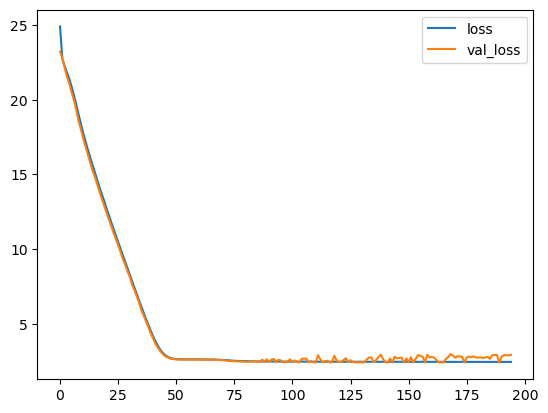

In [22]:
# Trains the data
history = model.fit(X_train, y_train, validation_data = (X_valid, y_valid), batch_size=BATCHSIZE, callbacks =[early_stopping, reduce_lr], epochs=EPOCHS)

#Plots and saves the loss curve
history_df = numpy.log(pd.DataFrame(history.history))
fig=plt.figure()
LossFigure = history_df.loc[:, ['loss', 'val_loss']].plot().get_figure()
LossFigure.savefig('Loss.png')

In [23]:
#Saves the model
model.save('Model')
model.save_weights('Model Weights.h5')

INFO:tensorflow:Assets written to: Model/assets


In [32]:
# Uses the model to predict validation set
pred = model.predict(tracks)
print("Pred 0 = ", pred[0])
print("Bhads 0 = ", bhads[0])
print("exp pred 0 = ", numpy.exp(pred[0]))
print("exp pred 4 0 = ", numpy.exp(pred[:,4][0]))

2130/2130 [==============================] - 2s 1ms/step
Pred 0 =  [ 1.5799552e+03  6.0997295e-01  1.1196030e+00  1.1447669e+01
 -1.1552682e+00 -1.3786500e+00 -2.3520100e+00 -5.0825751e-01
  8.4628886e-01]
Bhads 0 =  [1.37346188e+05 8.16028237e-01 1.20712149e+00]
exp pred 0 =  [          inf 1.8403817e+00 3.0636377e+00 9.3682711e+04 3.1497306e-01
 2.5191844e-01 9.5177658e-02 6.0154283e-01 2.3309801e+00]
exp pred 4 0 =  0.31497306


/tmp/ipykernel_7165/3073143090.py:5: RuntimeWarning: overflow encountered in exp
  print("exp pred 0 = ", numpy.exp(pred[0]))


In [33]:
# Saves the variables we want from the model
pTDiff=pred[:,0] - bhads[:,0]
pTErr= numpy.exp(pred[:,3])
Pull = pTDiff/pTErr


etaDiff = pred[:,1] - bhads[:,1]
etaErr = numpy.exp(pred[:, 4])
scaledEtaDiff = etaDiff/etaErr
print('eta max, min, mean = ' + str(numpy.max(etaDiff)), str(numpy.min(etaDiff)), str(numpy.mean(etaDiff)))
print('Scaled eta max, min, mean = ' + str(numpy.max(scaledEtaDiff)), str(numpy.min(scaledEtaDiff)), str(numpy.mean(scaledEtaDiff)))

phiDiff = pred[:,2] - bhads[:,2]
phiErr = numpy.exp(pred[:, 5])
scaledPhiDiff = phiDiff / phiErr
print('Phi max, min, mean = ' + str(numpy.max(phiDiff)), str(numpy.min(phiDiff)), str(numpy.mean(phiDiff)))
print('Scaled Phi max, min, mean = ' + str(numpy.max(scaledPhiDiff)), str(numpy.min(scaledPhiDiff)), str(numpy.mean(scaledPhiDiff)))

[11.447669 11.395547 11.365636 ... 11.483423 11.358631 11.466135]
[[ 1.37346188e+05  8.16028237e-01  1.20712149e+00]
 [ 7.71383594e+04  1.58197463e+00  1.55986178e+00]
 [ 9.88936328e+04 -2.40611649e+00 -2.47372627e+00]
 ...
 [ 9.80441562e+04 -4.61435974e-01  1.35823727e+00]
 [ 1.35274062e+05  2.03558505e-01  1.47211230e+00]
 [ 8.85507578e+04  2.74742275e-01  3.76518816e-02]]
pT max, min, mean = -80500.21571101296 -80500.21571101296 -80500.21571101296
Pull max, min, mean = -0.03205222332390968 -8.151986672710276 -0.8967839147916601
eta max, min, mean = 4.332607209682465 -4.269299566745758 -0.013792201614586792
Scaled eta max, min, mean = 5.66898145122972 -5.095958072709008 -0.0955206947877305
Phi max, min, mean = 6.002540111541748 -5.423507213592529 0.047878055206113976
Scaled Phi max, min, mean = 11.778710217077373 -6.425721486434648 0.05635452053803596


In [34]:
# Making the plots
#The loss curve


# The Histograms
fig = \
binneddensity \
( Pull
, fixedbinning(-5, 5, 100)
, xlabel="Pull"
)
fig.savefig("Pull.png")

fig = \
binneddensity \
( pTDiff
, fixedbinning(-200000, 200000, 100)
, xlabel="pT Difference"
)
fig.savefig("pT Difference.png")

fig = \
binneddensity \
( etaDiff
, fixedbinning(-5, 5, 100)
, xlabel="Eta Diff"
)
fig.savefig("Eta Diff.png")

fig = \
binneddensity \
( scaledEtaDiff
, fixedbinning(-5, 5, 100)
, xlabel="Scaled Eta Diff"
)
fig.savefig("scaled Eta Diff.png")

fig = \
binneddensity \
( phiDiff
, fixedbinning(-5, 5, 100)
, xlabel="Phi Diff"
)
fig.savefig("Phi Diff.png")

fig = \
binneddensity \
( scaledPhiDiff
, fixedbinning(-5, 5, 100)
, xlabel="Scaled Phi Diff"
)
fig.savefig("Scaled Phi Diff.png")

#Input plots
jetz0sintheta = features["AnalysisTracks_z0sinTheta"]
impactParam = features["AnalysisTracks_d0"]
impactParamSig = features["AnalysisTracks_d0sig"]
impactParamPV = features["AnalysisTracks_d0PV"]
impactParamPVSig = features["AnalysisTracks_d0sigPV"]
fig = \
  binneddensity \
  ( jetz0sintheta[:,0] # the first jet in each event
  , fixedbinning(-1, 1, 500) # 50 bins from 0 to 2
  , xlabel="Transverse IP * sin(Theta)"
  )
fig.savefig("TransverseIP.png")

fig = \
  binneddensity \
  ( impactParam[:,0] # the first jet in each event
  , fixedbinning(-1, 1, 500) # 50 bins from 0 to 2
  , xlabel="Impact Parameter"
  )
fig.savefig("Impact Parameter.png")

fig = \
  binneddensity \
  ( impactParamSig[:,0] # the first jet in each event
  , fixedbinning(-4, 4, 100) # 50 bins from 0 to 2
  , xlabel="Impact Parameter Sig"
  )
fig.savefig("Impact Parameter Sig.png")

fig = \
  binneddensity \
  ( impactParamPV[:,0] # the first jet in each event
  , fixedbinning(-0.5, 0.5, 250) # 50 bins from 0 to 2
  , xlabel="Impact Parameter (PV)"
  )
fig.savefig("Impact Parameter PV.png")

fig = \
  binneddensity \
  ( impactParamPVSig[:,0] # the first jet in each event
  , fixedbinning(-4, 4, 100) # 100 bins from -3 to 3
  , xlabel="Impact Parameter Sig (PV)"
  )
fig.savefig("Impact Parameter PV Sig.png")

In [35]:
#Print any results we want
print('pT Diff Mean = ' + str(numpy.mean(pTDiff)))
print('pT Diff Median = ' + str(numpy.median(pTDiff)))
print('pT Diff Std = ' + str(numpy.std(pTDiff)))
print('pT Diff IQR = ' + str(numpy.percentile(pTDiff, 75)-numpy.percentile(pTDiff, 25)))
print('Pull Mean = ' + str(numpy.mean(Pull)))
print('Pull Median = ' + str(numpy.median(Pull)))
print('Pull Std = ' + str(numpy.std(Pull)))
print('Pull IQR = ' + str(numpy.percentile(Pull, 75)-numpy.percentile(Pull, 25)))

pT Diff Mean = -80500.21571101296
pT Diff Median = -72636.23315429688
pT Diff Std = 42394.12964007519
pT Diff IQR = 46339.808532714844
Pull Mean = -0.8967839147916601
Pull Median = -0.8141169630021852
Pull Std = 0.4621993441448002
Pull IQR = 0.5094972920245513


In [ ]:
quit()
# this creates histograms of truth jet values.
truthjetspt = features["AnalysisAntiKt4TruthJets_pt"] 
truthjetseta = features["AnalysisAntiKt4TruthJets_eta"]
truthjetsphi = features["AnalysisAntiKt4TruthJets_phi"]


fig = \
  binneddensity \
  ( truthjetspt[:,0] # the first jet in each event
  , fixedbinning(0, 200000, 50) # 50 bins from 0 to 200000 MeV
  , xlabel="First truth jet $p_T$ [MeV]"
  )

fig.savefig("truthjet-pt-comb.png")

fig = \
  binneddensity \
  ( truthjetseta[:,0] # the first jet in each event
  , fixedbinning(-5, 5, 50) # 50 bins from 0 to 5
  , xlabel="First truth jet pseudorepidity"
  )
fig.savefig("truthjet-eta-comb.png")

fig = \
  binneddensity \
  ( truthjetsphi[:,0] # the first jet in each event
  , fixedbinning(0, 3.15, 50) # 50 bins from 0 to pi rad
  , xlabel="First truth jet phi [rad]"
  )
fig.savefig("truthjet-phi-comb.png")


# this creates histograms of the reconstructed jet values.
reconstructedjetspt = features["AnalysisJets_pt_NOSYS"]
reconstructedjetseta = features["AnalysisJets_eta"]
reconstructedjetsphi = features["AnalysisJets_phi"]


pt_filt = []
eta_filt = []
phi_filt = []

for x in range(len(reconstructedjetspt)):
    if numpy.sum(numpy.absolute(reconstructedjetspt[x])) != 0:
        pt_filt.append(reconstructedjetspt[x][0])
    if numpy.sum(numpy.absolute(reconstructedjetseta[x])) != 0:
        eta_filt.append(reconstructedjetseta[x][0])
    if numpy.sum(numpy.absolute(reconstructedjetsphi[x])) != 0:
        phi_filt.append(reconstructedjetsphi[x][0])

fig = \
  binneddensity \
  ( pt_filt # the first jet in each event
  , fixedbinning(0, 200000, 50) # 50 bins from 0 to 200000 MeV
  , xlabel="Reconstructed jet $p_T$ [MeV]"
  )
fig.savefig("Reconstructedjet-pT-comb.png")

fig = \
  binneddensity \
  ( eta_filt # the first jet in each event
  , fixedbinning(-5, 5, 50) # 50 bins from -5 to 5
  , xlabel="Reconstructed jet pseudorapidity"
  )
fig.savefig("reconstructedjet-eta-comb.png")

fig = \
  binneddensity \
  ( phi_filt # the first jet in each event
  , fixedbinning(0, 3.15, 50) # 50 bins from 0 to pi rad
  , xlabel="Reconstructed jet phi [rad]"
  )
fig.savefig("reconstructedjet-phi-comb.png")


#this creates a histogram of b-hadron pTs
b_hadron_pt = features["AnalysisAntiKt4TruthJets_ghostB_pt"] 
b_hadron_pt = awkward.flatten(b_hadron_pt, axis = None)

fig = \
  binneddensity \
  ( b_hadron_pt #the hadron pTs
  , fixedbinning(0, 200000, 50) # 50 bins from 0 to 200000 MeV
  , xlabel = "B-Hadron $p_T$ [MeV]"
  )
fig.savefig("ptDist.png")

# this counts the number of b-hadron identification numbers and prints out the
# counts.
# these are defined in the PDG (but no need to worry about the details for now!)
# https://pdg.lbl.gov/2007/reviews/montecarlorpp.pdf


truthbhadronsid = \
  awkward.flatten \
  ( features["AnalysisAntiKt4TruthJets_ghostB_pdgId"]
  , axis=None
  )

# loop over all the b-hadrons associated to jets
counts = {}
for bhadid in truthbhadronsid:
  if bhadid in counts:
    counts[bhadid] += 1
  else:
    counts[bhadid] = 1

print()
for bhadid in counts:
  print("PDG ID:", bhadid)
  print("number of b-hadrons:", counts[bhadid])
  print()


PDG ID: 531
number of b-hadrons: 13487

PDG ID: -521
number of b-hadrons: 61531

PDG ID: -511
number of b-hadrons: 61243

PDG ID: 5232
number of b-hadrons: 751

PDG ID: 511
number of b-hadrons: 61706

PDG ID: 521
number of b-hadrons: 61594

PDG ID: -531
number of b-hadrons: 13526

PDG ID: -5122
number of b-hadrons: 5447

PDG ID: 5122
number of b-hadrons: 5232

PDG ID: -5132
number of b-hadrons: 676

PDG ID: 5132
number of b-hadrons: 722

PDG ID: -5232
number of b-hadrons: 733

PDG ID: 555
number of b-hadrons: 3

PDG ID: 553
number of b-hadrons: 6

PDG ID: -5332
number of b-hadrons: 21

PDG ID: 5332
number of b-hadrons: 18

PDG ID: 100553
number of b-hadrons: 1

PDG ID: -541
number of b-hadrons: 5

PDG ID: 10551
number of b-hadrons: 3

PDG ID: 541
number of b-hadrons: 5

PDG ID: 20553
number of b-hadrons: 1

